In [1]:
#imports
import pandas as pd 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#questionable imports 
%matplotlib inline 
import numpy as np

In [2]:
#get data into python 

#Kp and ap data from 1932
kpdata = pd.read_csv('kp_ap_since_1932.txt', skiprows=29, sep='\s+', header=0, index_col=False)

#Sunspot data from 1818 
sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, sep='\s+', header=0, index_col=False, usecols=['YYYY', 'M', 'DD', 'D,FYR', 'SS#', 'SDEV', '#OBS'], na_values=['-1'])

#rename first 3 cols
sndata.columns = ['Year', 'Month', 'Day', 'D,FYR', 'SS#', 'SDEV', '#OBS'] 

#Make time series so pd.series functions work
sndata['time']=sndata[['Year', 'Month', 'Day']].apply(lambda s: pd.datetime(*s),axis = 1)

C:\Users\jackb\AppData\Local\Temp\ipykernel_26892\1513880727.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sndata = pd.read_csv('SN_d_tot_V2.0.txt', error_bad_lines=False, sep='\s+', header=0, index_col=False, usecols=['YYYY', 'M', 'DD', 'D,FYR', 'SS#', 'SDEV', '#OBS'], na_values=['-1'])
C:\Users\jackb\AppData\Local\Temp\ipykernel_26892\1513880727.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  sndata['time']=sndata[['Year', 'Month', 'Day']].apply(lambda s: pd.datetime(*s),axis = 1)


#### Plot Raw Data

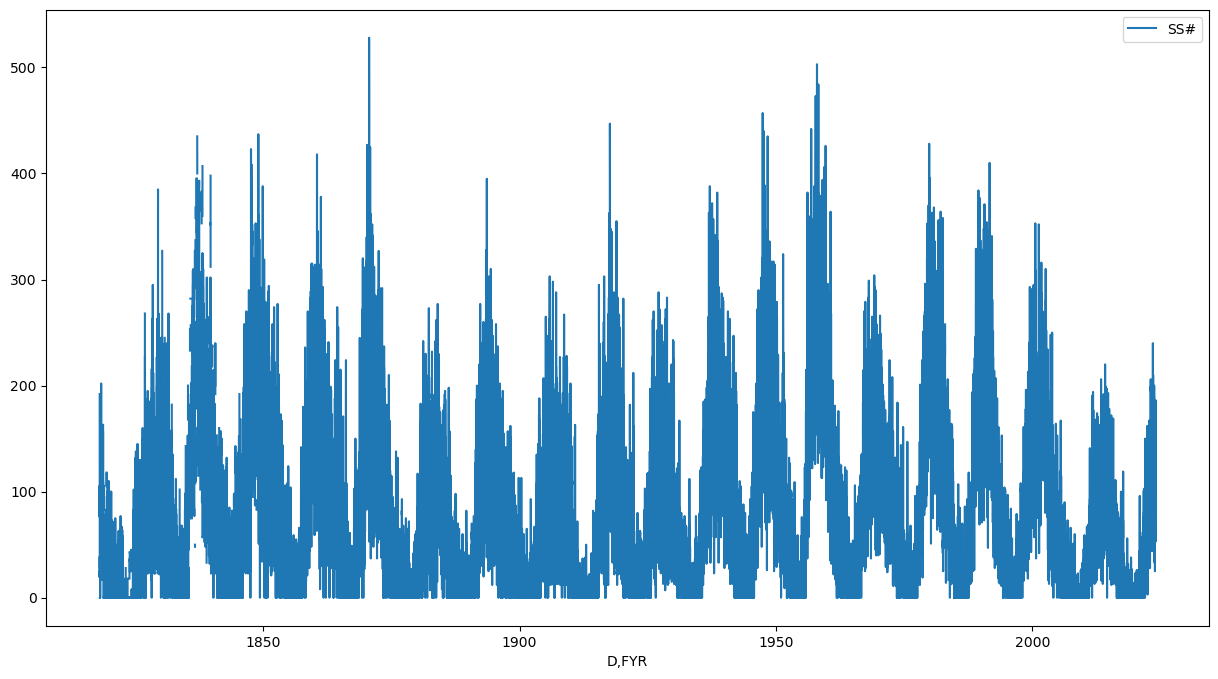

In [3]:
#plot sndata SS# vs D,FYR for visual inspection
sndata.plot(x='D,FYR', y='SS#', kind='line')
legend = ['Sunspot Number']
plt.gcf().set_size_inches(15, 8)

### Comparing a Max Year with a Min Year

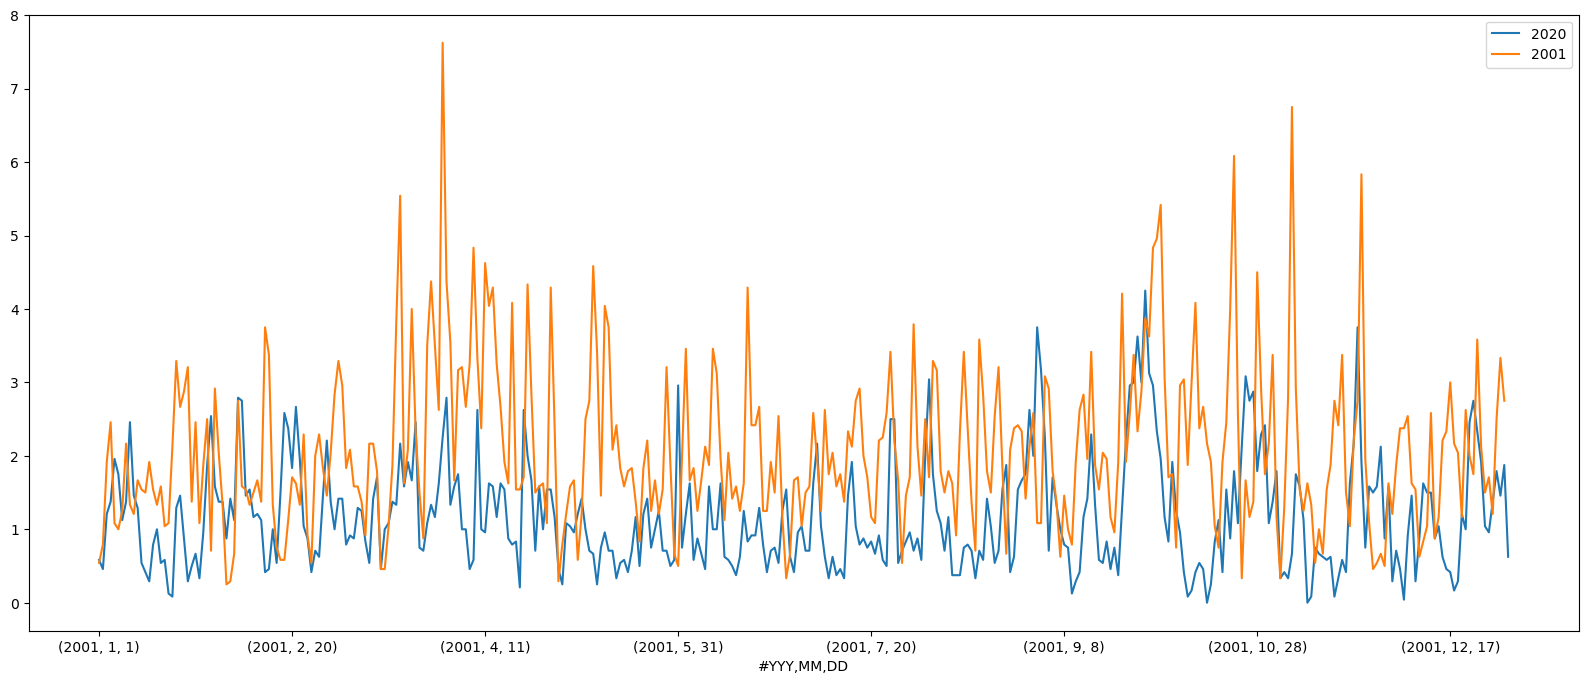

In [4]:
#This block shows that on average in more active years (solar max vs solar min yrs) the Kp index is higher
plt.figure(figsize=(20, 8))

#2020 is a solar min year
year1 = 2020
daily_avgs = kpdata[kpdata['#YYY'] == year1].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year1)

#2001 is a solar max year
year2 = 2001
daily_avgs = kpdata[kpdata['#YYY'] == year2].groupby(['#YYY', 'MM', 'DD']).mean()['Kp']
daily_avgs.plot(label=year2)

plt.legend()

### Interpolation

In [25]:
#this block creates the time series for the sunspot data
ts = pd.Series(data=sndata['SS#'].values, index=sndata['time'])

#interpolate data to fill in NaN(-1) values **FIX//REPOSITION**
ts = ts.interpolate(method='linear')

Daily total sunspot number derived by the formula: R= Ns + 10 * Ng, with Ns the number of spots and Ng the number of groups counted over the entire solar disk (The 2-D image of the sun that the viewer is looking at).

### Monthly

time
1818-01-01           NaN
1818-01-02           NaN
1818-01-03           NaN
1818-01-04           NaN
1818-01-05           NaN
1818-01-06           NaN
1818-01-07           NaN
1818-01-08     65.000000
1818-01-09     59.400000
1818-01-10     53.800000
1818-01-11     48.200000
1818-01-12     42.600000
1818-01-13     37.000000
1818-01-14     47.000000
1818-01-15     57.000000
1818-01-16     67.000000
1818-01-17     77.000000
1818-01-18     98.000000
1818-01-19    105.000000
1818-01-20     91.666667
dtype: float64


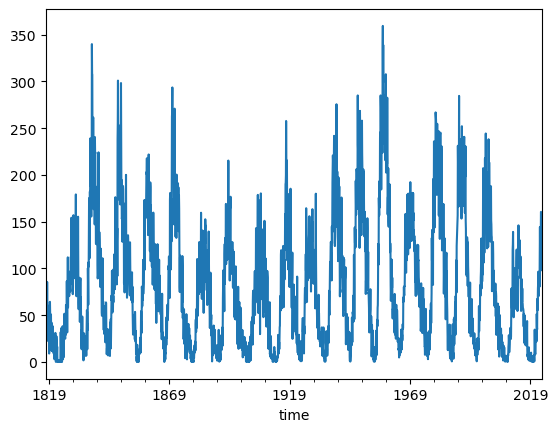

c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


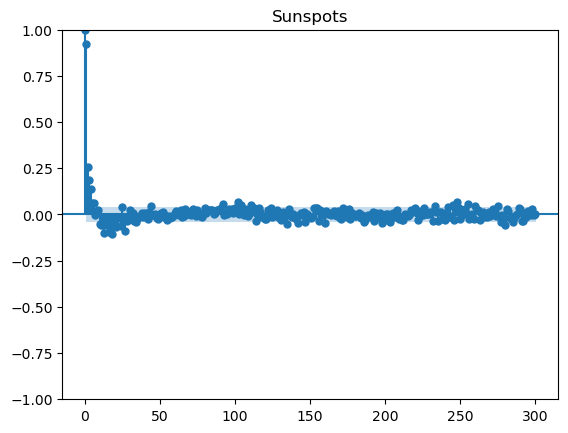

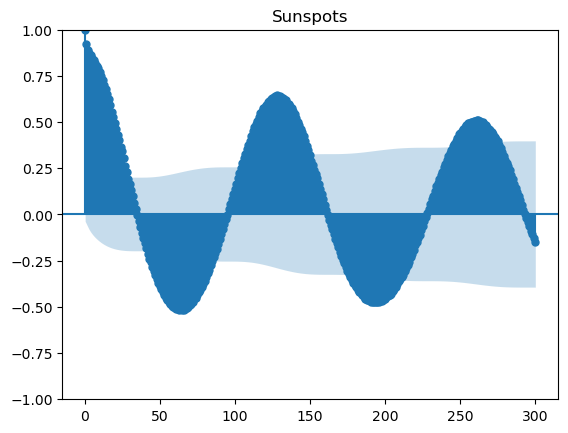

In [6]:
#this block splits makes the monthly ts for sarima experimentation

#print first 20 rows of ts
print(ts.head(20))

ts_month = ts.resample('MS').mean()
ts_month.plot()
plt.show()

#this block plots information needed for trend parameters: order = (p,d,q)
plot_pacf(ts_month,lags=300,title='Sunspots')
plt.show()

plot_acf(ts_month,lags=300,title='Sunspots')
plt.show()

#SARIMAX TAKES 10+ MINUTES TO RUN, MONTHLY 

### Quarterly

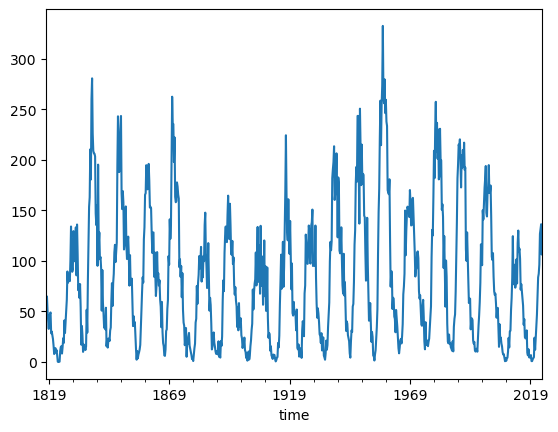

c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


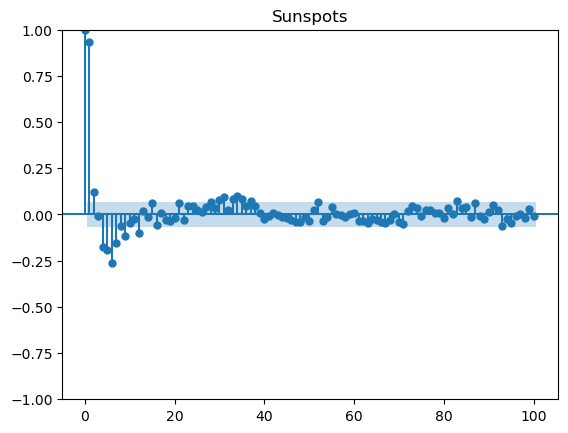

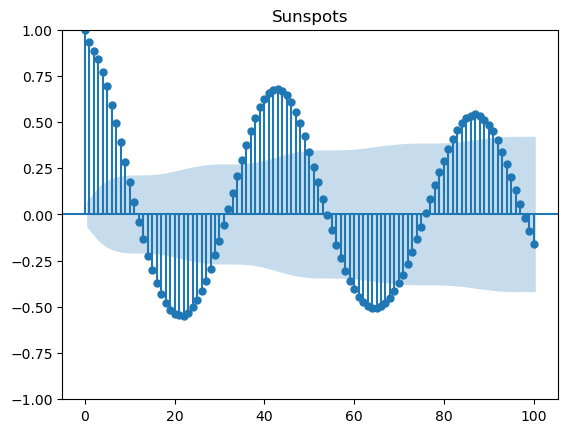

In [7]:
ts_qtr = ts.resample('Q').mean()
ts_qtr.plot()
plt.show()

#this block plots information needed for trend parameters: order = (p,d,q)
plot_pacf(ts_qtr,lags=100,title='Sunspots')
plt.show()

plot_acf(ts_qtr,lags=100,title='Sunspots')
plt.show()

### SARIMAX (Quarterly - 3 months)

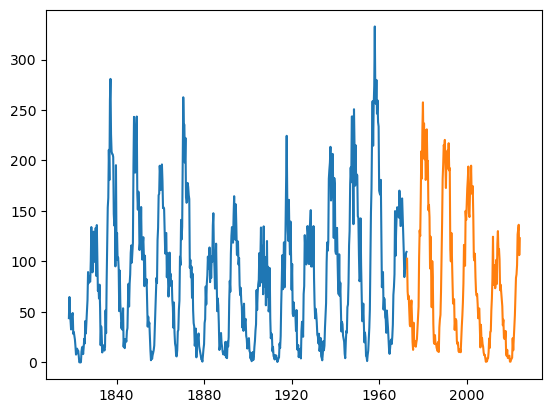

In [9]:
ts_train = ts_qtr[:int(0.75*(len(ts_qtr)))]
ts_test = ts_qtr[int(0.75*(len(ts_qtr))):]

plt.plot(ts_train)
plt.plot(ts_test)

In [10]:
model = sm.tsa.statespace.SARIMAX(ts_train, order=(3,0,10), seasonal_order=(1,1,0,43), trend='n')
results = model.fit()
print(results.summary())

c:\Users\jackb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  618
Model:             SARIMAX(3, 0, 10)x(1, 1, [], 43)   Log Likelihood               -2699.046
Date:                              Tue, 26 Mar 2024   AIC                           5428.093
Time:                                      14:44:49   BIC                           5493.408
Sample:                                  03-31-1818   HQIC                          5453.567
                                       - 06-30-1972                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8744      0.150      5.826      0.000       0.580       1.169
ar.L2          0.76

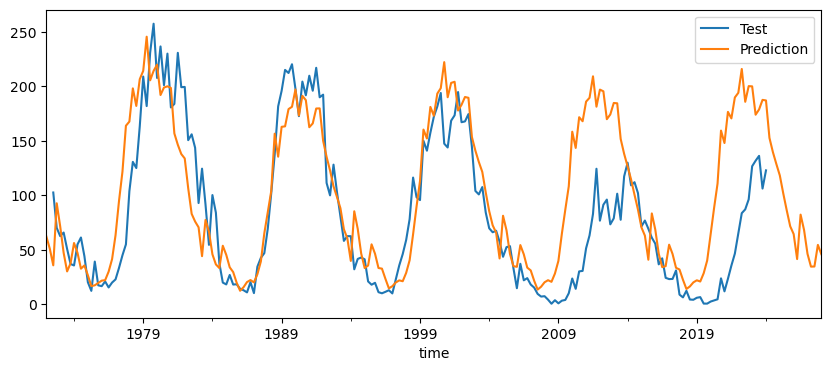

In [11]:
plt.figure(figsize=(10, 4))
forecast = results.predict(start = ts_train.index[-2], end= ts_test.index[-2] + pd.DateOffset(months=50),dynamic= True) 
ts_test.plot(label='Test')
forecast.plot(label='Prediction')
# plt.show()
plt.legend()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print('Mean Squared Error:', mean_squared_error(ts_test, forecast[:len(ts_test)]))
print('Mean Absolute Error:', mean_absolute_error(ts_test, forecast[:len(ts_test)]))
print('Root Mean Squared Error:', (mean_squared_error(ts_test, forecast[:len(ts_test)]))**0.5)
print('R2 Score:', r2_score(ts_test, forecast[:len(ts_test)]))


Mean Squared Error: 2200.5476663619625
Mean Absolute Error: 35.084816279133115
Root Mean Squared Error: 46.90999537797848
R2 Score: 0.5170823688116062


### Gridsearch, stepwise, and parameters

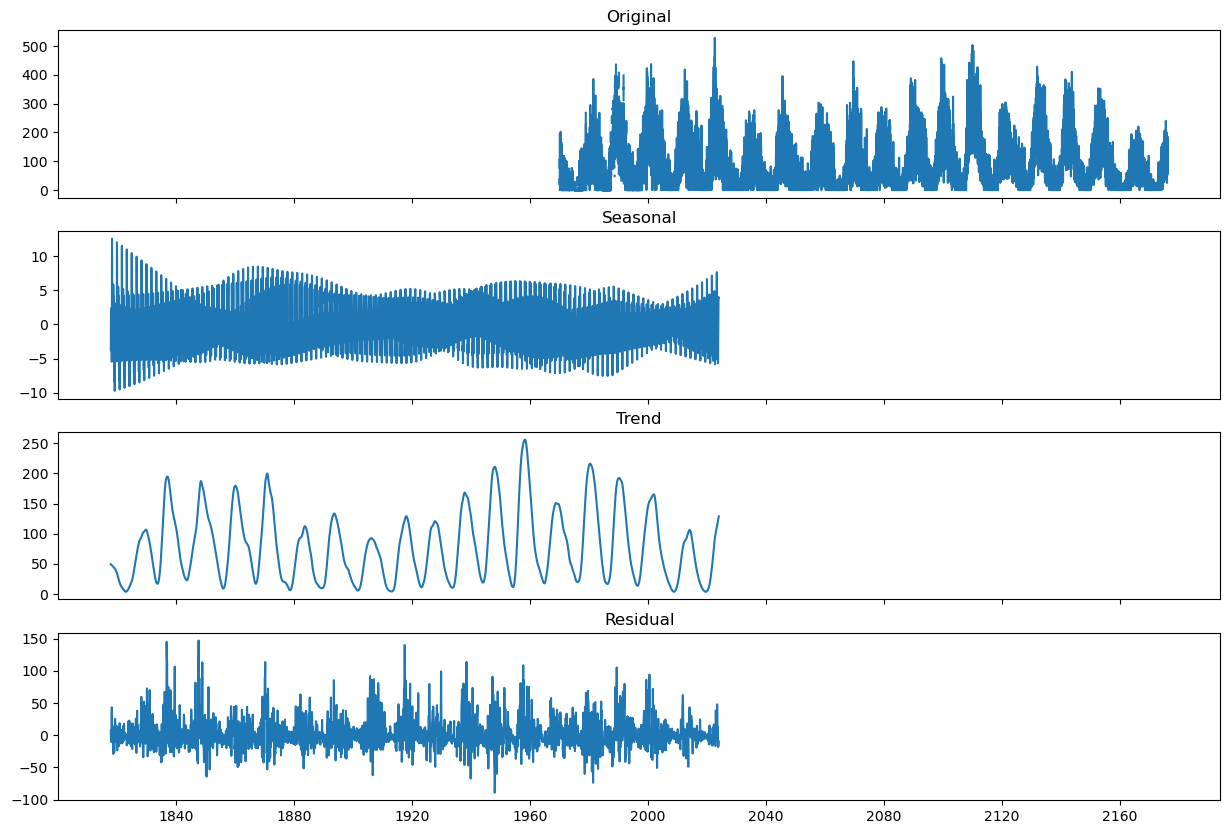

In [34]:
#seasonal trend decomposition 
from statsmodels.tsa.seasonal import STL

graphs = STL(endog=ts_month, period=20, seasonal=43, robust=True).fit()
seasonal, trend, resid = graphs.seasonal, graphs.trend, graphs.resid

ig, axs = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
axs[0].plot(sndata['SS#'])
axs[0].set_title('Original')
axs[1].plot(seasonal)
axs[1].set_title('Seasonal')
axs[2].plot(trend)
axs[2].set_title('Trend')
axs[3].plot(resid)
axs[3].set_title('Residual')
plt.show()

#seasonal trend decomposition using LOESS
